In [1]:
import dask
from dask.distributed import Client
import deepdish as dd
import h5py
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import xarray as xr
import zarr

import casingSimulations as casing_sim
from SimPEG import maps
from SimPEG.electromagnetics import time_domain as tdem
from pymatsolver import Pardiso

np.random.seed(29)

In [2]:
directory = "test"

if not os.path.isdir(directory):
    os.makedirs(directory, exist_ok=True)

In [3]:
from matplotlib import rcParams
rcParams["font.size"] = 16

In [4]:
nsamples = 2

In [5]:
# set bounds for the distributions of 
sigma_background_bounds = np.r_[1e-4, 1]
sigma_casing_bounds = np.r_[1e4, 1e7]

d_casing_bounds = np.r_[5e-2, 30e-2]
t_casing_bounds = np.r_[0.5e-2, 2e-2]
l_casing_bounds = np.r_[50, 4e3]

In [6]:
# constants
sigma_air = 1e-4
sigma_inside = 1  # fluid inside the casing
mur_casing = 1  # permeability is the same as free space

src_a = np.r_[0., 0., 0.]  # the radius will be updated to connect to the casing
src_b = np.r_[1000., 0, 0]

csz = 2.5  # cell-size in the z-direction
hy = np.ones(12)
hy = hy*2*np.pi / hy.sum()

In [7]:
# areas to compare data

z_compare = np.linspace(-100, 0, 128)

In [8]:
def generate_random_variables(bounds, n_samples, sig_digs=None):
    min_value = bounds.min()
    max_value = bounds.max()
    v = np.random.rand(n_samples)
    v = min_value + (v*(max_value - min_value))
    if sig_digs is not None:
        v = np.round((v*10**(sig_digs)))/10**(sig_digs)
    return v

In [9]:
log10_sigma_background_dist = generate_random_variables(np.log10(sigma_background_bounds), nsamples, 2)
log10_sigma_casing_dist = generate_random_variables(np.log10(sigma_casing_bounds), nsamples, 2)

d_casing_dist = generate_random_variables(d_casing_bounds, nsamples, 2) 
t_casing_dist = generate_random_variables(t_casing_bounds, nsamples, 2) 
l_casing_dist = np.r_[100, 100]  #generate_random_variables(l_casing_bounds/csz, nsamples, 0) * csz # generate by ncells

parameters = {
    "log10_sigma_background":log10_sigma_background_dist,
    "log10_sigma_casing":log10_sigma_casing_dist,
    "d_casing":d_casing_dist,
    "t_casing":t_casing_dist,
    "l_casing":l_casing_dist,
}

In [10]:
df = pd.DataFrame(parameters)
df

,log10_sigma_background,log10_sigma_casing,d_casing,t_casing,l_casing
0,-0.54,4.22,0.16,0.02,100
1,-2.86,6.29,0.19,0.02,100


In [11]:
df.shape

(2, 5)

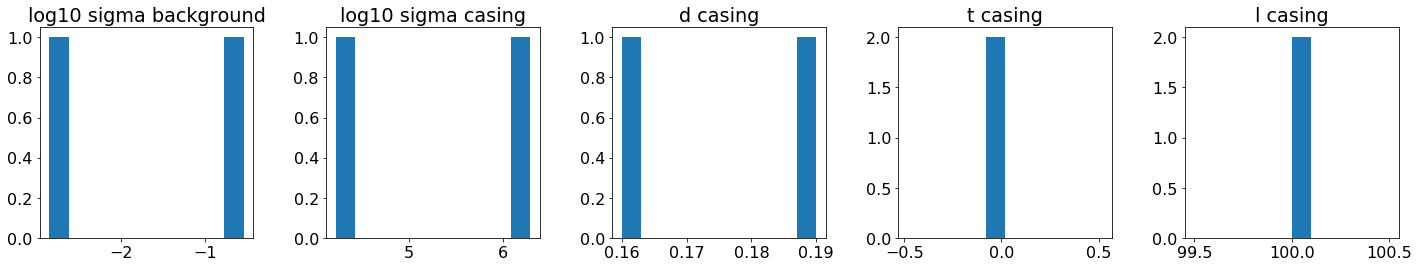

In [12]:
fig, ax = plt.subplots(1,5, figsize=(20, 4))

for i, key in enumerate(parameters.keys()):
    ax[i].hist(df[key])
    ax[i].set_title(f"{key}".replace("_", " "))

plt.tight_layout()

In [13]:
parameters["l_casing"]

array([100, 100])

In [14]:
time_steps = np.logspace(-6, -2, 128)

In [15]:
i = 0

[df.loc[i].to_hdf(f"{directory}/trial_{i}.h5", key) for key in df.loc[i].keys()]

trial_directory = f"{directory}/trial_{i}/"
if not os.path.isdir(trial_directory):
    os.makedirs(trial_directory, exist_ok=True)

cd = parameters["d_casing"][i]
ct = parameters["t_casing"][i]
cl = parameters["l_casing"][i]

sc = 10**(parameters["log10_sigma_casing"][i])
sb = 10**(parameters["log10_sigma_background"][i])



In [16]:
model = casing_sim.model.CasingInHalfspace(
    directory=trial_directory,
    casing_d = cd - ct,  # I use diameter to the center of the casing wall
    casing_l = cl,
    casing_t = ct, 
    mur_casing = mur_casing,
    sigma_air = sigma_air,
    sigma_casing = sc,
    sigma_back = sb,
    sigma_inside = sb,
    src_a = src_a,
    src_b = src_b,
    timeSteps = time_steps
)
model.filename = "casing.json"

In [17]:
sigmaA = model.sigma_casing * (model.casing_b**2 - model.casing_a**2)/model.casing_b**2
print(f"The approximate conductivity of the solid we use is {sigmaA:1.1e}")

model_approx_casing = model.copy()
model_approx_casing.sigma_inside = sigmaA
model_approx_casing.sigma_casing = sigmaA
model_approx_casing.filename = "approx_casing.json"

The approximate conductivity of the solid we use is 7.3e+03


In [18]:
meshGen = casing_sim.mesh.CasingMeshGenerator(
    modelParameters = model, 
    csx1 = model.casing_t/4,
    csx2 = 100,
    domain_x = cl,  # use 2.5m cells out to 300m. 
    hy = hy,
    npadx = 8, # 6
    npadz = 17,  #14
    csz = csz,
)
mesh = meshGen.mesh

742.8652886064586


/global/homes/l/lheagy/.conda/envs/simpeg37/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


(0, 1100)

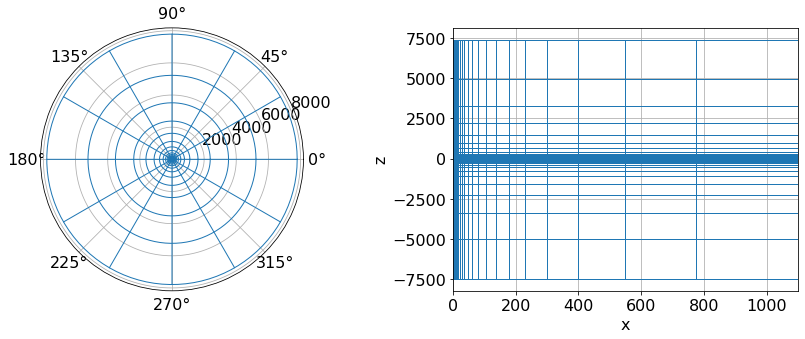

In [19]:
print(model.diffusion_distance(t=0.1))
ax = mesh.plotGrid()

ax[1].set_xlim([0, 1100])

In [20]:
src_theta = np.pi/2. + mesh.hy[0]/2.
model.src_a[1] = src_theta
model.src_b[1] = src_theta


In [21]:
src_top = casing_sim.sources.TopCasingSrc(
    modelParameters=model, 
    meshGenerator=meshGen,
    src_a=model.src_a,
    src_b=model.src_b,
    physics="TDEM",
    filename="top_casing",
)

source_list = src_top.srcList

In [22]:
model.sigma(mesh)

array([2.8840315e-01, 2.8840315e-01, 2.8840315e-01, ..., 1.0000000e-04,
       1.0000000e-04, 1.0000000e-04])

In [23]:
np.save(f"{trial_directory}casing.npy", model.sigma(mesh))
np.save(f"{trial_directory}approx_casing.npy", model_approx_casing.sigma(mesh))

In [24]:
survey = tdem.Survey(source_list)

In [25]:
sim = tdem.Problem3D_j(
    mesh=mesh, survey=survey, solver=Pardiso,
    time_steps=time_steps
)

dd.io.save(f"{trial_directory}simulation.h5", sim.serialize())

with open(f"{trial_directory}simulation.json", 'w') as outfile:
    json.dump(sim.serialize(), outfile)

/global/homes/l/lheagy/.conda/envs/simpeg37/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


In [26]:
def compute_fields(model, trial_directory):
    import deepdish as dd
    import discretize
    import casingSimulations as casing_sim
    from SimPEG.electromagnetics import time_domain as tdem
    from SimPEG import maps
    from pymatsolver import Pardiso
    
    simulation_params = dd.io.load(f"{trial_directory}simulation.h5")
#     print(f"{trial_directory}simulation.json")
#     simulation_parameters = json.loads(f"{trial_directory}simulation.json")
    sim = tdem.Problem3D_j.deserialize(simulation_params, trusted=True)
    sim.solver = Pardiso
    sim.sigmaMap=maps.IdentityMap(mesh)
    
    m = np.load(f"{trial_directory}{model}.npy")
    fields = sim.fields(m)
    f = fields[:, '{}Solution'.format(sim._fieldType), :]

    if name is not None: 
        filename = f"{model}.npy"
        tosave = os.path.sep.join([trial_directory, filename]) 
        print(f"saving {tosave}")
        np.save(tosave, f)
    
    return tosave

In [27]:
client = Client(threads_per_worker=1, n_workers=2)
client

Client Scheduler: tcp://127.0.0.1:38219 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 540.15 GB


In [28]:
f = {}
for m in ["casing", "approx_casing"]:
    f[m] = compute_fields(m, trial_directory)
#     f[m] = dask.delayed(compute_fields)(m, trial_directory)

ValueError: Could not load boolean from JSON: False

In [ ]:
%debug

> /global/homes/l/lheagy/.local/lib/python3.7/site-packages/properties/basic.py(754)from_json()
    752         if isinstance(value, int):
    753             return value
--> 754         raise ValueError('Could not load boolean from JSON: {}'.format(value))
    755 
    756 



ipdb>  u


> /global/homes/l/lheagy/.local/lib/python3.7/site-packages/properties/basic.py(314)deserialize()
    312         if value is None:
    313             return None
--> 314         return self.from_json(value, **kwargs)
    315 
    316     @staticmethod



ipdb>  self


ipdb>  value


False


ipdb>  u


> /global/homes/l/lheagy/.local/lib/python3.7/site-packages/properties/base/base.py(576)deserialize()
    574         newstate = {}
    575         for key, val in iteritems(state):
--> 576             newstate[key] = output_cls._props[key].deserialize(val, **kwargs)
    577         mutable, immutable = utils.filter_props(output_cls, newstate, False)
    578         with handlers.listeners_disabled():



ipdb>  key


'integrate'


In [68]:
fields_files = dask.compute(f)[0]

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [53]:
%debug

> /global/homes/l/lheagy/.conda/envs/simpeg37/lib/python3.7/site-packages/properties/basic.py(757)from_json()
    755         if isinstance(value, int):
    756             return value
--> 757         raise ValueError('Could not load boolean from JSON: {}'.format(value))
    758 
    759 



ipdb>  u


> /global/homes/l/lheagy/.conda/envs/simpeg37/lib/python3.7/site-packages/properties/basic.py(314)deserialize()
    312         if value is None:
    313             return None
--> 314         return self.from_json(value, **kwargs)
    315 
    316     @staticmethod



ipdb>  u


> /global/homes/l/lheagy/.conda/envs/simpeg37/lib/python3.7/site-packages/properties/base/base.py(549)deserialize()
    547         newstate = {}
    548         for key, val in iteritems(state):
--> 549             newstate[key] = output_cls._props[key].deserialize(val, **kwargs)
    550         mutable, immutable = utils.filter_props(output_cls, newstate, False)
    551         with handlers.listeners_disabled():



ipdb>  key


*** NameError: name 'key' is not defined


ipdb>  val


*** NameError: name 'val' is not defined


ipdb>  u


> /global/homes/l/lheagy/.conda/envs/simpeg37/lib/python3.7/site-packages/properties/base/instance.py(154)deserialize()
    152             return None
    153         if issubclass(self.instance_class, HasProperties):
--> 154             return self.instance_class.deserialize(value, **kwargs)
    155         return self.from_json(value, **kwargs)
    156 



ipdb>  u


> /global/homes/l/lheagy/.conda/envs/simpeg37/lib/python3.7/site-packages/properties/base/containers.py(326)<listcomp>()
    324             return None
    325         output_list = [self.prop.deserialize(val, **kwargs)
--> 326                        for val in value]
    327         return self._class_container(output_list)
    328 



ipdb>  val


*** NameError: name 'val' is not defined


ipdb>  kwargs


*** NameError: name 'kwargs' is not defined


ipdb>  quit


In [42]:
ndata = 32
xsample = np.linspace(5, 1000, ndata)
zsample = np.linspace(-cl, 0, ndata)